In [28]:
import tensorflow as tf
import utils as u
import optimizers as opt
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import product
from seaborn import heatmap

In [29]:
(x, y, z) = u.generate_data(N=500, random_ax=True, noise_scale=0.1, mesh=False)

In [30]:
deg = 3
D = u.build_design_matrix(X=x, Y=y, degree=deg)


In [31]:
X_train, X_test, Z_train, Z_test = train_test_split(D, np.squeeze(z), test_size=0.33, shuffle=False)

In [32]:
[X_train, X_test, Z_train, Z_test] = [tf.constant(arr, dtype=tf.float32) for arr in (X_train, X_test, Z_train, Z_test)]

In [33]:
def linear_model(x, model):
    return tf.reduce_sum(x*model, axis=1)

In [34]:
def mse(Z_true, Z_pred):
    return tf.reduce_mean(((Z_true - Z_pred)**2))

In [35]:
def cod(Z_true, Z_pred):
    rss = tf.reduce_sum(((Z_true - Z_pred)**2))
    tss = tf.reduce_sum(((Z_true - tf.reduce_mean(Z_true))**2))

    return 1 - rss / tss

In [36]:
from matplotlib import pyplot as plt

In [37]:
init_beta = tf.random.normal([D.shape[1]], 0, 0.01)


In [38]:
init_beta

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.00513582, -0.00141594,  0.00842494, -0.00804585,  0.00892417,
       -0.00991703,  0.00400022,  0.01860317, -0.00429807, -0.00051272],
      dtype=float32)>

In [39]:
def experiment_loop(X_train, Z_train, X_test, Z_test, init_beta, init_optimizer, batch_size = None,  l2_reg = 0., n_steps=100):

    optimizer = deepcopy(init_optimizer)
    if not batch_size:
        batch_size = X_train.shape[0]
    model_params = tf.Variable(init_beta[:D.shape[1]])

    loss_history = {'train_loss': list(), 'test_loss': list()}
    for epoch in tqdm(range(n_steps)):
        random_idx = np.random.permutation(X_train.shape[0])
        X_train, Z_train = tf.gather(X_train, random_idx), tf.gather(Z_train, random_idx)
        n_batches = (X_train.shape[0] // batch_size) + 1
        for ii in range(n_batches):
            X_batch = X_train[ii*batch_size : (ii+1)*batch_size, :]
            Z_batch = Z_train[ii*batch_size : (ii+1)*batch_size]
            with tf.GradientTape() as tape:
                Z_pred = linear_model(X_batch, model_params)
                batch_loss = mse(Z_batch, Z_pred) + l2_reg*tf.reduce_sum(model_params**2)
            batch_gradients = tape.gradient(batch_loss, model_params)
            optimizer.apply_gradients(batch_gradients, model_params)
        loss_history['train_loss'].append(mse(Z_train, linear_model(X_train, model_params)))
        loss_history['test_loss'].append(mse(Z_test, linear_model(X_test, model_params)))
    training_log = loss_history
    return training_log, model_params



In [40]:
def ridge_loop(learning_rates = np.logspace(0, -5, num=20), l2_rates = np.logspace(0, -5, num=10), n_steps=100, init_beta = init_beta, optimizer_class =opt.SGD, batch_size=None, **optimizer_kwargs):

    test_mse = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates)), dtype=tf.float32))
    train_mse = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates)), dtype=tf.float32))
    test_cod = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates)), dtype=tf.float32))
    train_cod = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates)), dtype=tf.float32))
    for lr_id, l2_id in product(range(len(learning_rates)), range(len(l2_rates))):
        optimizer = optimizer_class(lr = learning_rates[lr_id], **optimizer_kwargs)
        history_GD, model = experiment_loop(X_train, Z_train, X_test, Z_test, init_beta, optimizer, l2_reg=l2_rates[l2_id], n_steps=n_steps, batch_size=batch_size)
        test_mse[lr_id, l2_id].assign(mse(Z_test, linear_model(X_test, model)))
        train_mse[lr_id, l2_id].assign(mse(Z_train, linear_model(X_train, model)))
        test_cod[lr_id, l2_id].assign(cod(Z_test, linear_model(X_test, model)))
        train_cod[lr_id, l2_id].assign(cod(Z_train, linear_model(X_train, model)))
    return test_mse, train_mse, test_cod, train_cod

In [41]:
default_learning_rates = np.logspace(0, -5, num=20)
default_l2_rates = np.logspace(0, -5, num=10)

## Plain gradient descent with a fixed learning rate

In [42]:
n_steps = 1000
learning_rates = np.logspace(-1, -7, num=20)
l2_rates = np.logspace(-1, -7, num=20)
test_mse = tf.Variable(tf.zeros((20, 20), dtype=tf.float32))
train_mse = tf.Variable(tf.zeros((20, 20), dtype=tf.float32))
test_cod = tf.Variable(tf.zeros((20, 20), dtype=tf.float32))
train_cod = tf.Variable(tf.zeros((20, 20), dtype=tf.float32))
for lr_id, l2_id in product(range(len(learning_rates)), range(len(l2_rates))):
    optimizer = opt.SGD(lr = learning_rates[lr_id])
    history_GD, model = experiment_loop(X_train, Z_train, X_test, Z_test, init_beta, optimizer, l2_reg=l2_rates[l2_id], n_steps=n_steps)
    test_mse[lr_id, l2_id].assign(mse(Z_test, linear_model(X_test, model)))
    train_mse[lr_id, l2_id].assign(mse(Z_train, linear_model(X_train, model)))
    test_cod[lr_id, l2_id].assign(cod(Z_test, linear_model(X_test, model)))
    train_cod[lr_id, l2_id].assign(cod(Z_train, linear_model(X_train, model)))
    #print(f'Epoch {epoch} loss: {cross_entropy(Z_train, logistic_function(X_train, model_params))}')


100%|██████████| 1000/1000 [00:06<00:00, 164.16it/s]


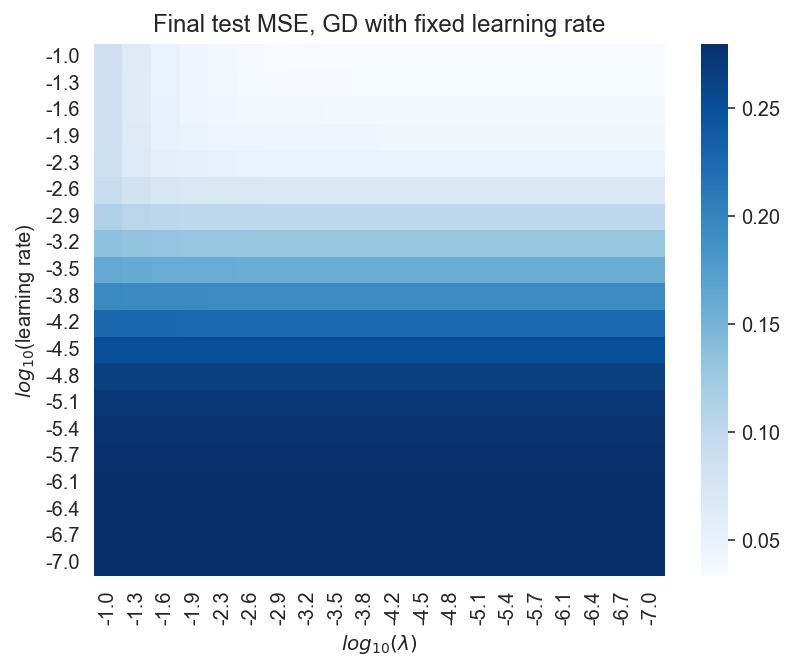

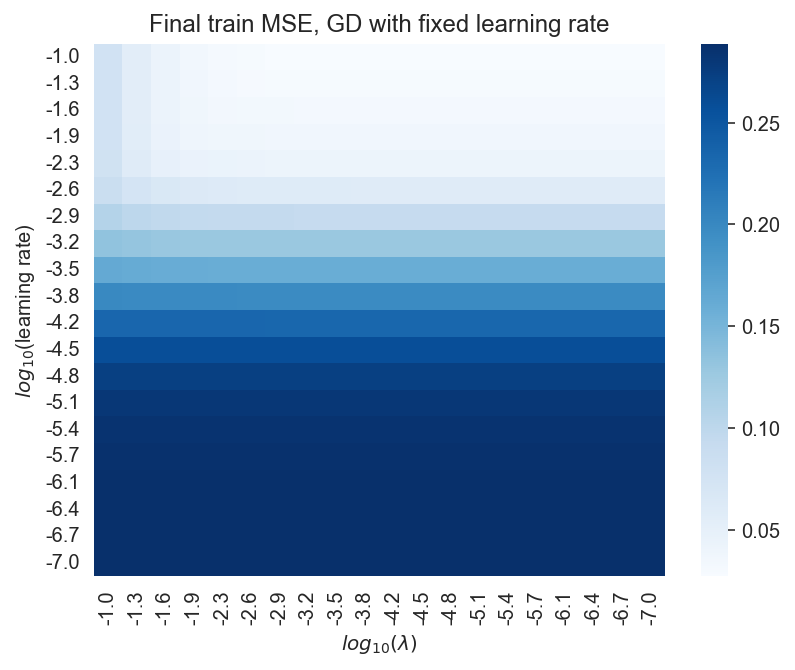

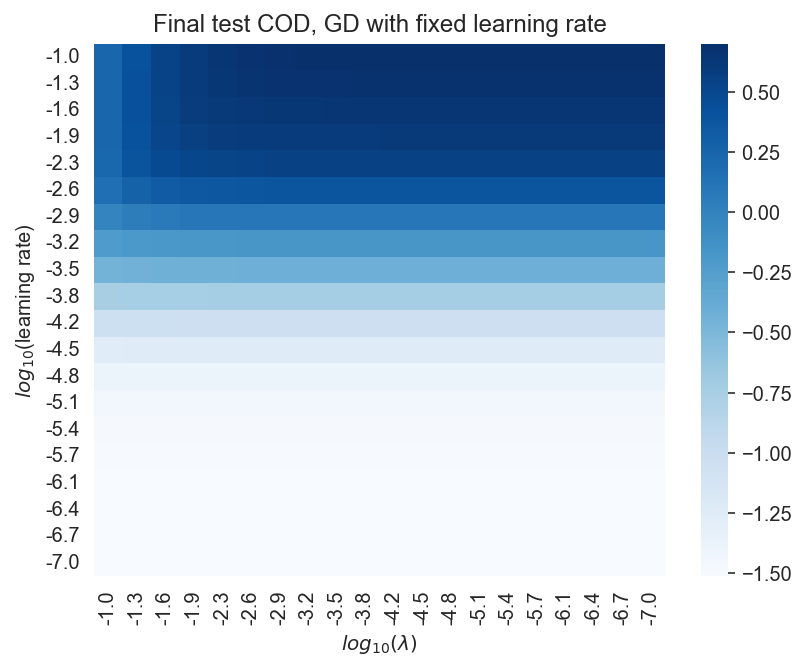

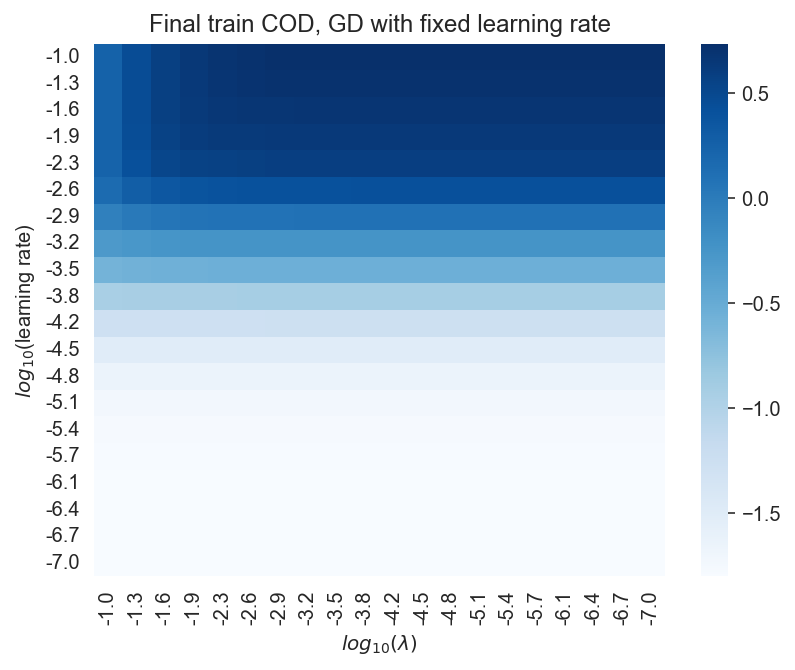

In [43]:
for tensor, desc in zip(
        (test_mse, train_mse, test_cod, train_cod),
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor, cmap=plt.cm.Blues, xticklabels=np.round(np.log10(learning_rates), 1), yticklabels=np.round(np.log10(l2_rates), 1))
    ax.set(title=f'Final {desc}, GD with fixed learning rate', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.show()


## Gradient descent with momentum

In [44]:

momentum_rates = np.arange(0, 11) / 10.
momentum_gd_results = ridge_loop(l2_rates=np.logspace(0, -5, num=10), momentum_rate=0.2)



100%|██████████| 100/100 [00:00<00:00, 180.70it/s]


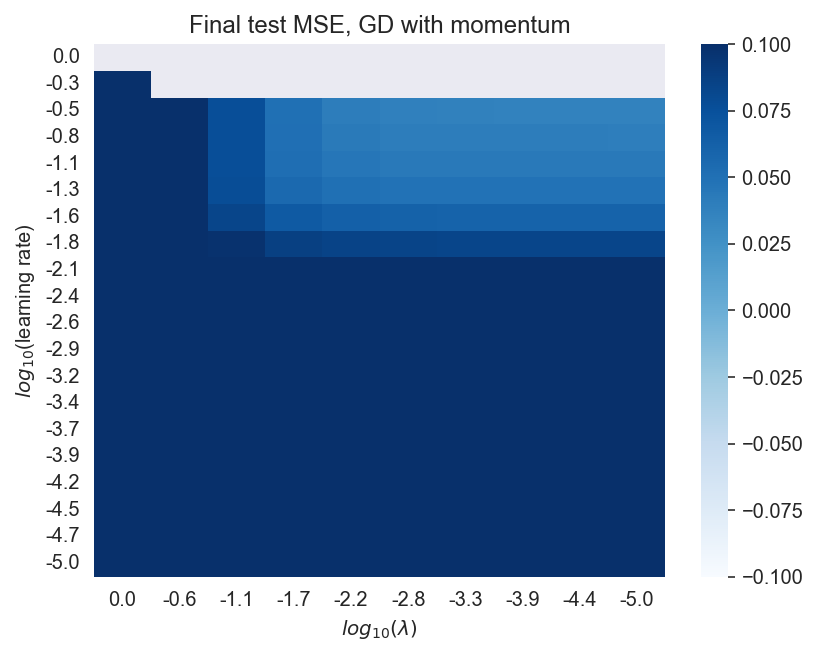

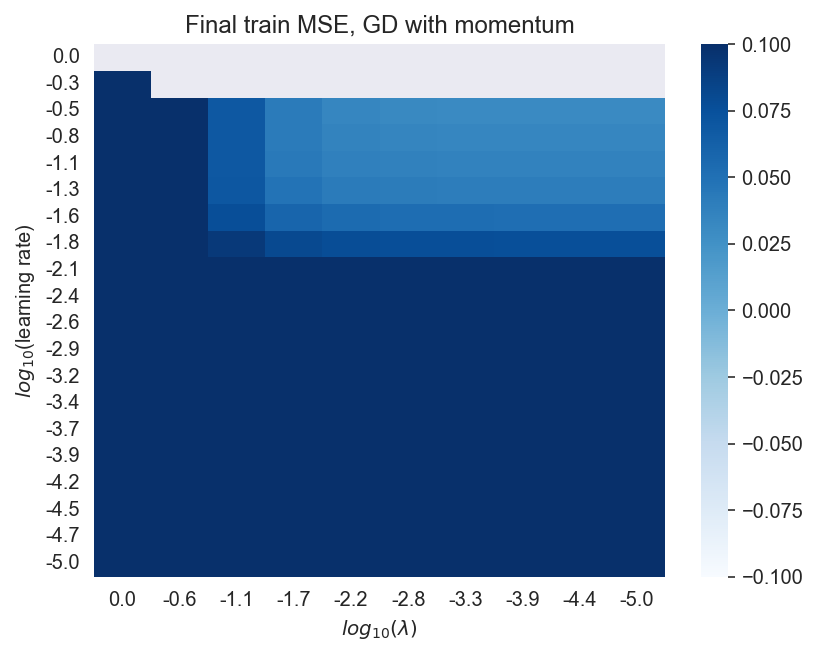

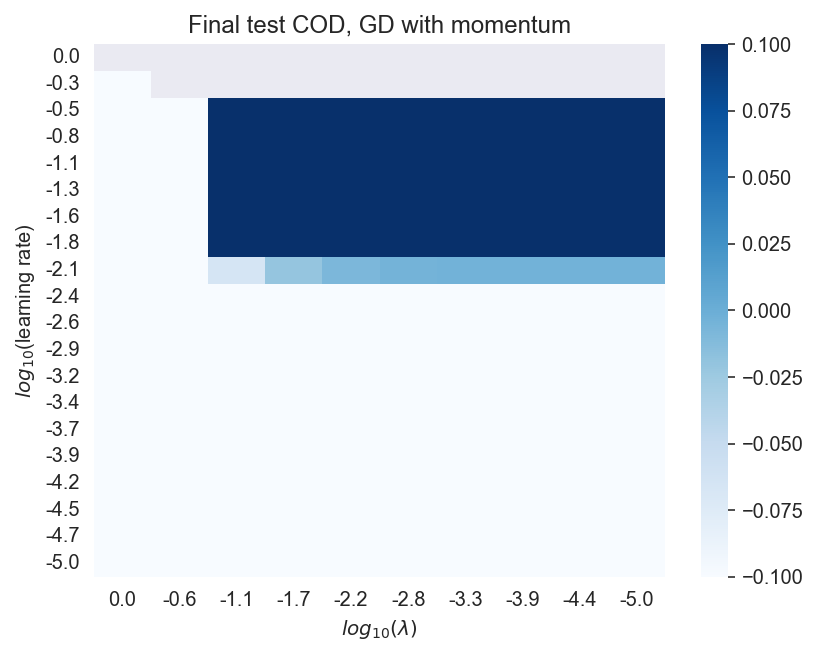

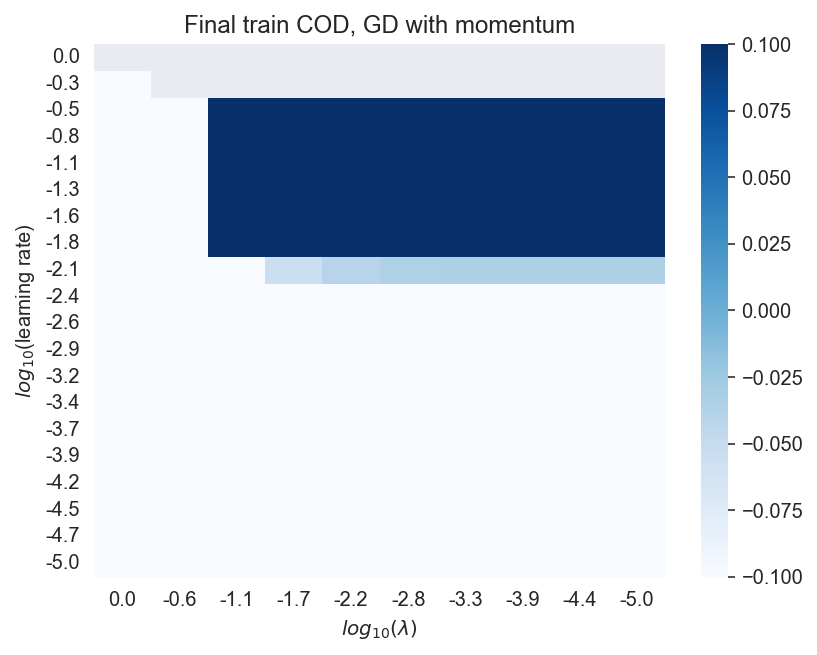

In [45]:
for tensor, desc in zip(
        momentum_gd_results,
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor, cmap=plt.cm.Blues, xticklabels=np.round(np.log10(np.logspace(0, -5, num=10)), 1), yticklabels=np.round(np.log10(default_learning_rates), 1))
    ax.set(title=f'Final {desc}, GD with momentum', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.show()

## Stochastic gradient descent with momentum

100%|██████████| 100/100 [00:00<00:00, 178.04it/s]


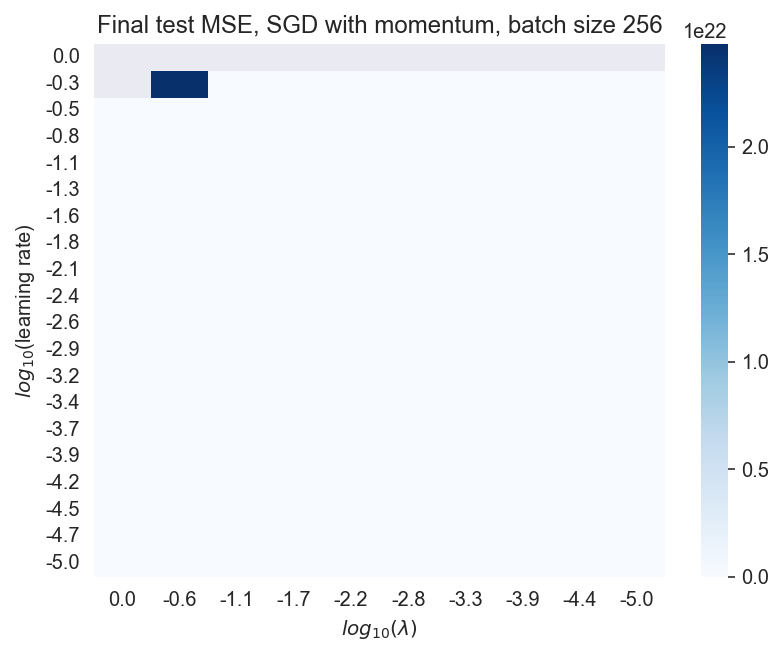

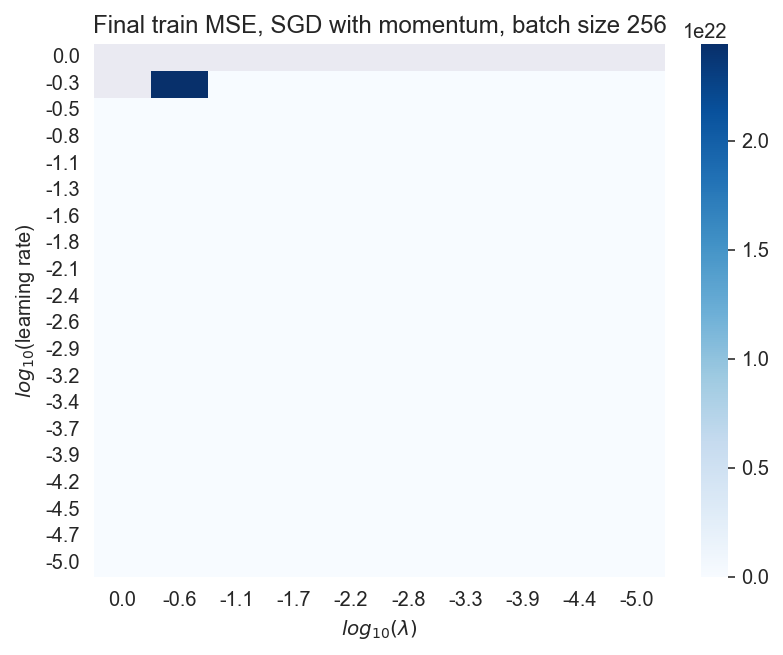

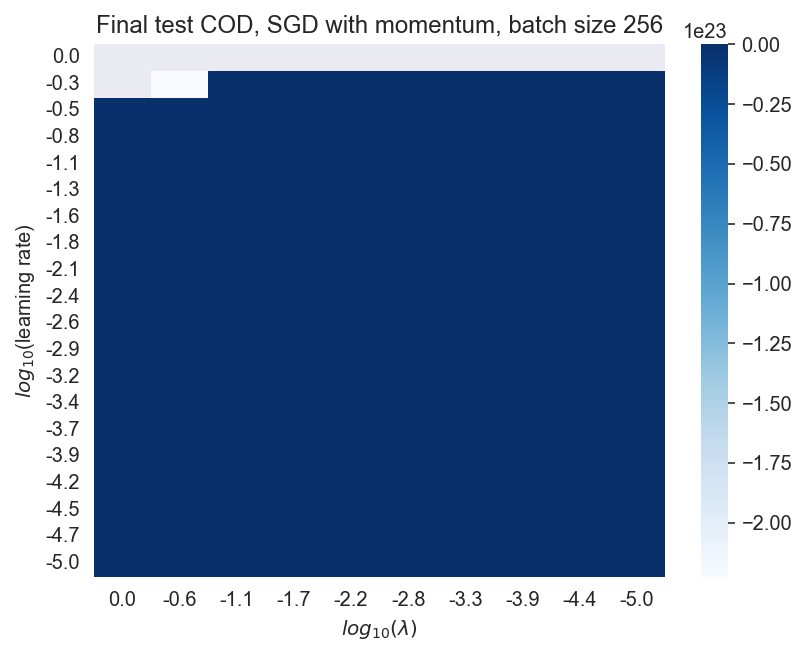

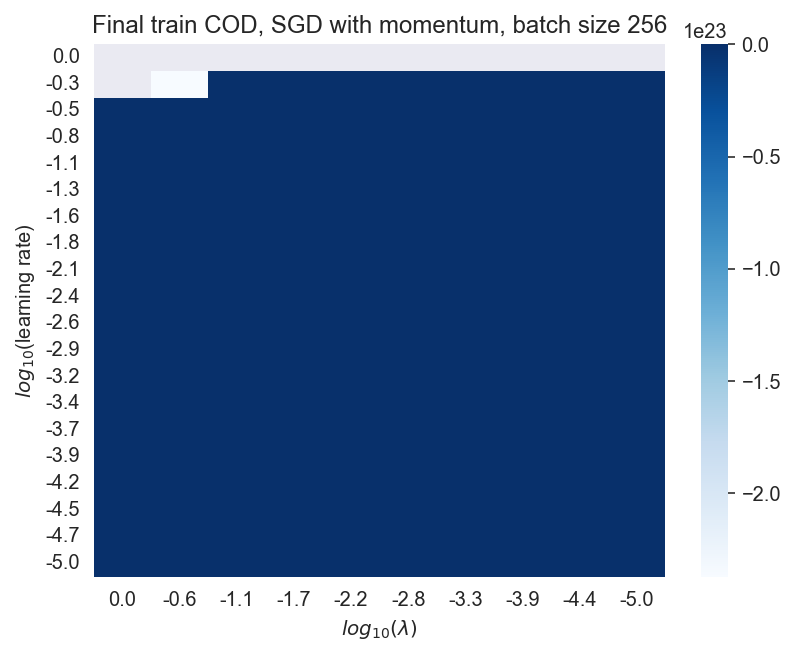

In [46]:

momentum_rates = np.arange(0, 11) / 10.
momentum_sgd_results = ridge_loop(batch_size=256, momentum_rate=0.2)

for tensor, desc in zip(
        momentum_sgd_results,
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor, cmap=plt.cm.Blues, xticklabels=np.round(np.log10(default_l2_rates), 1),
            yticklabels=np.round(np.log10(default_learning_rates), 1))
    ax.set(title=f'Final {desc}, SGD with momentum, batch size 256', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.show()

## Tuning the learning rate with Adagrad

100%|██████████| 100/100 [00:00<00:00, 272.24it/s]


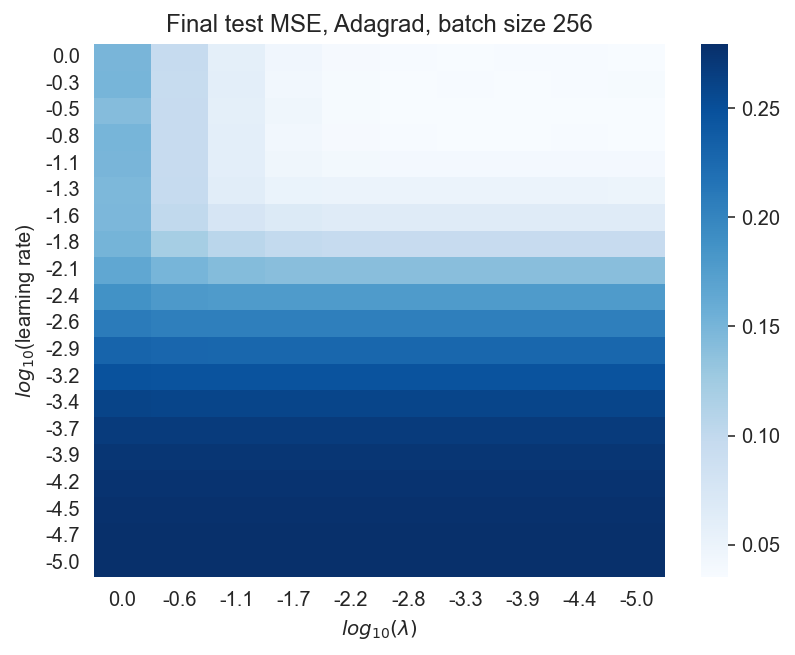

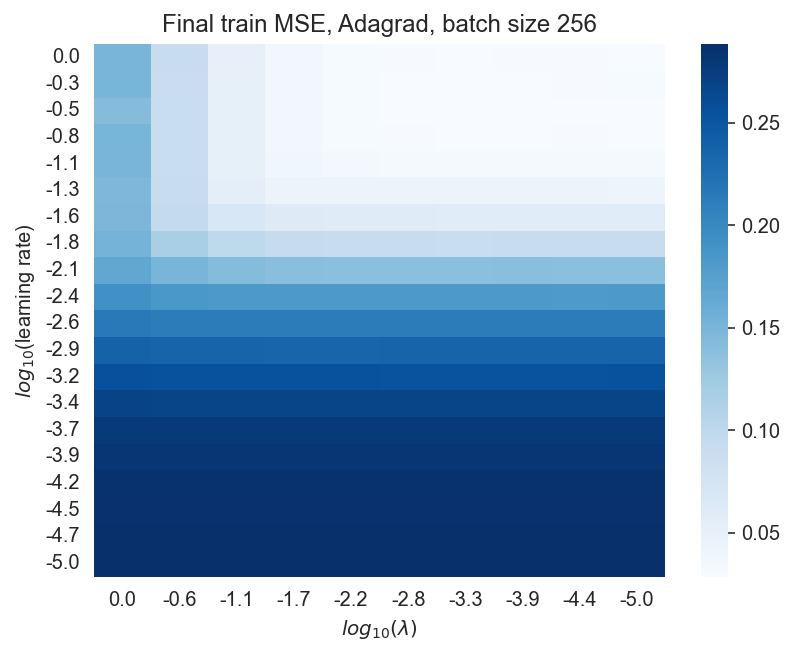

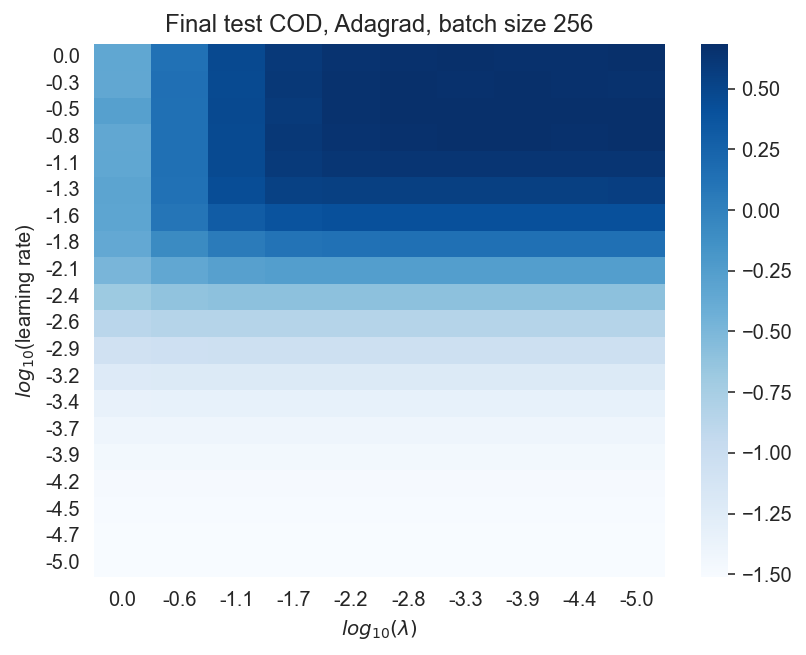

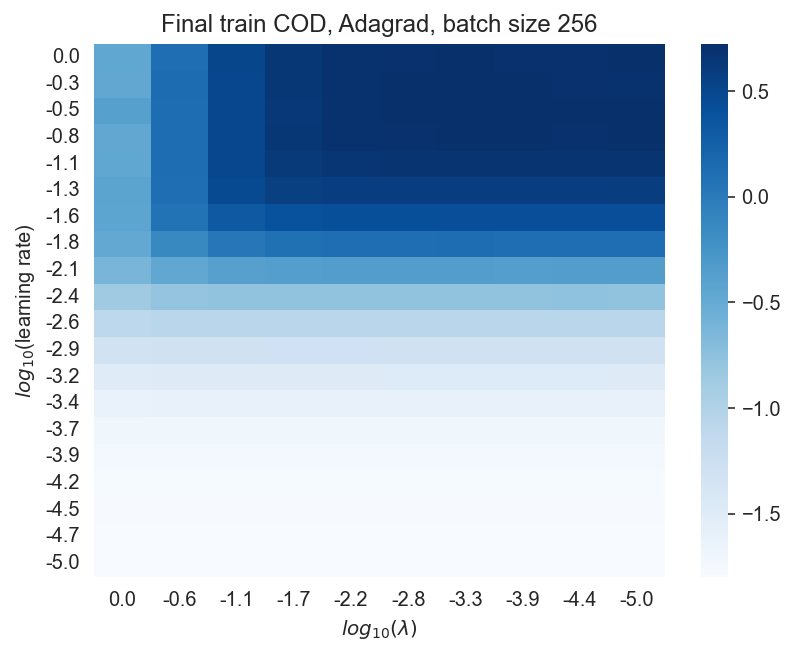

In [47]:
adagrad_results = ridge_loop(batch_size=256, optimizer_class=opt.AdaGrad, var_shape=(10))

for tensor, desc in zip(
        adagrad_results,
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor, cmap=plt.cm.Blues, xticklabels=np.round(np.log10(default_l2_rates), 1),
            yticklabels=np.round(np.log10(default_learning_rates), 1))
    ax.set(title=f'Final {desc}, Adagrad, batch size 256', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.show()


## Tuning the learning rate with RMSProp

In [48]:
rms_results = ridge_loop(batch_size=256, optimizer_class=opt.RMSProp, var_shape=(10))

100%|██████████| 100/100 [00:00<00:00, 263.66it/s]


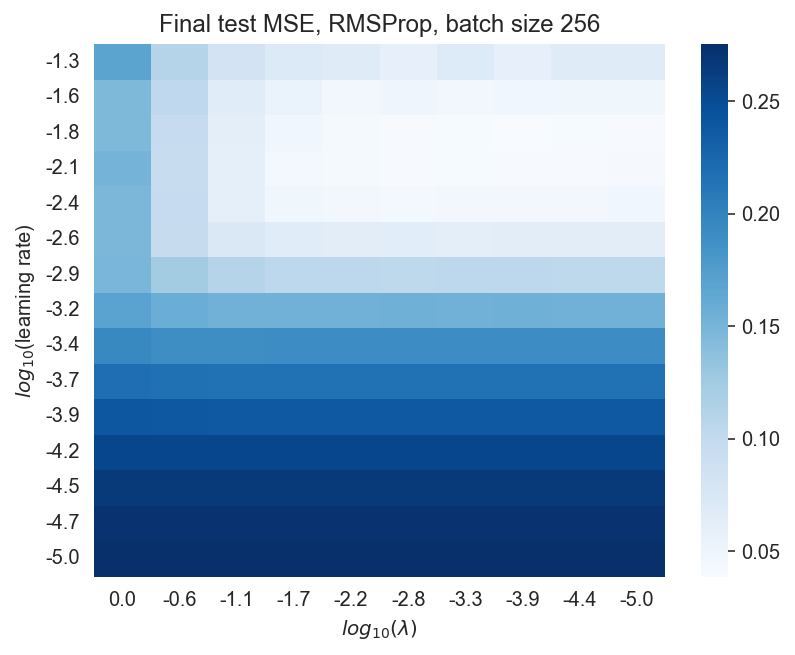

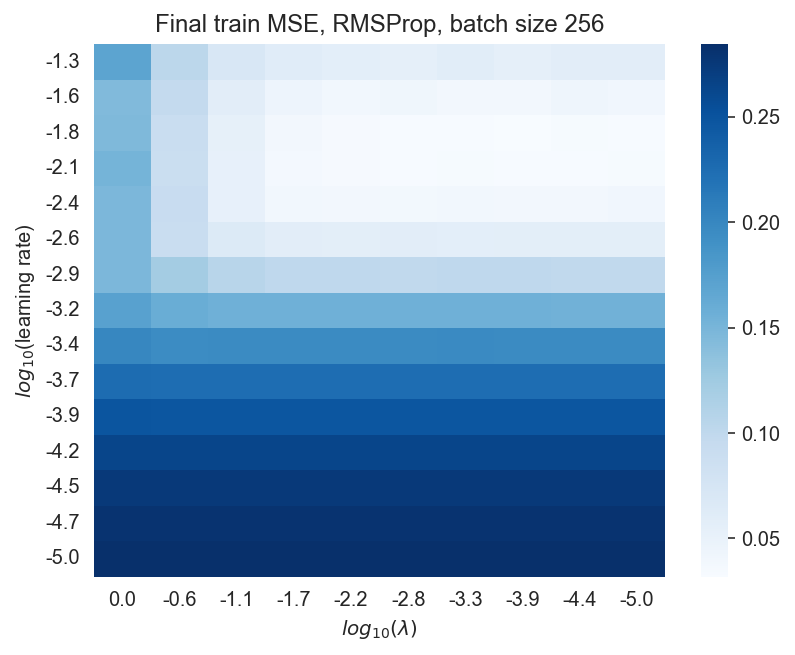

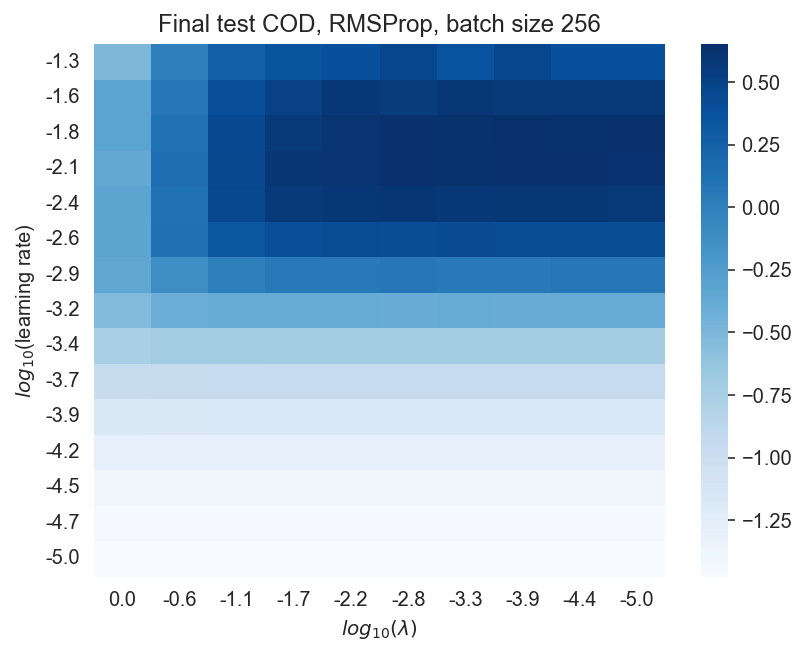

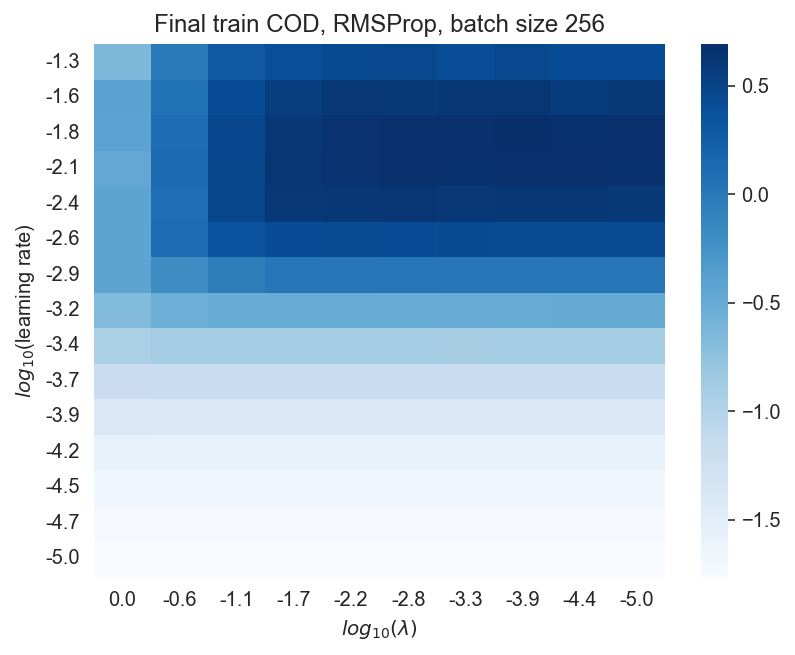

In [55]:

for tensor, desc in zip(
        rms_results,
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap((tensor[5:, ...]), cmap=plt.cm.Blues, xticklabels=np.round(np.log10(default_l2_rates), 1),
            yticklabels=np.round(np.log10(default_learning_rates[5:, ...]), 1))
    ax.set(title=f'Final {desc}, RMSProp, batch size 256', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.yticks(rotation=0)
    plt.show()

## Tuning the learning rate with ADAM

100%|██████████| 100/100 [00:00<00:00, 229.84it/s]


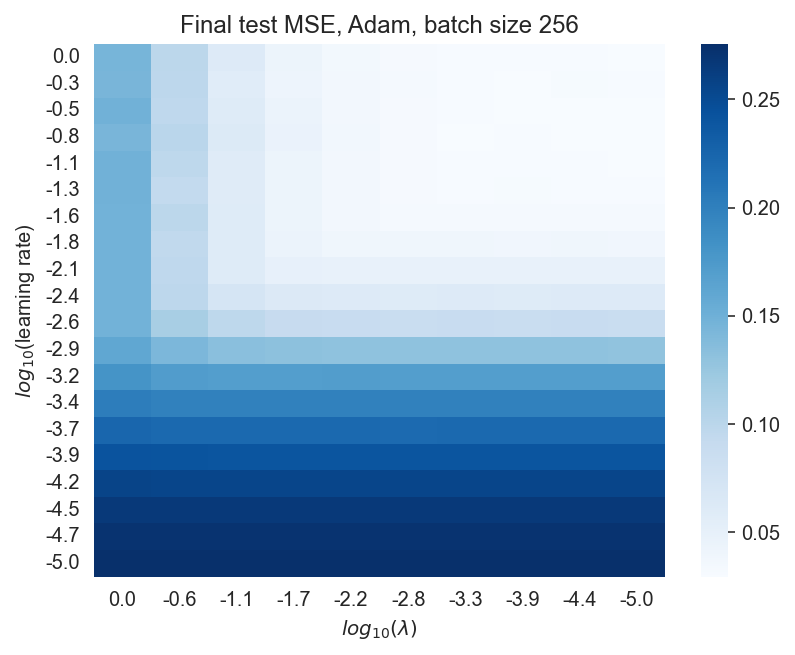

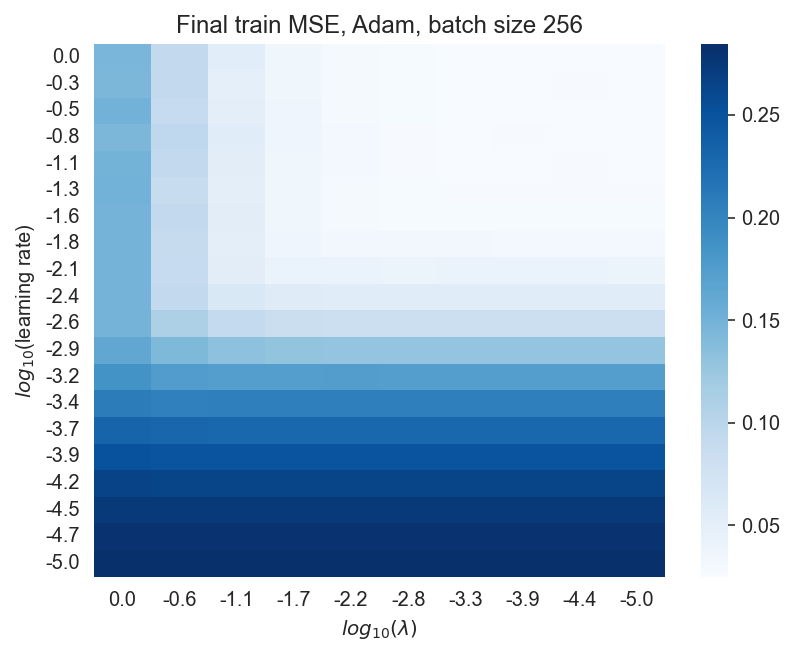

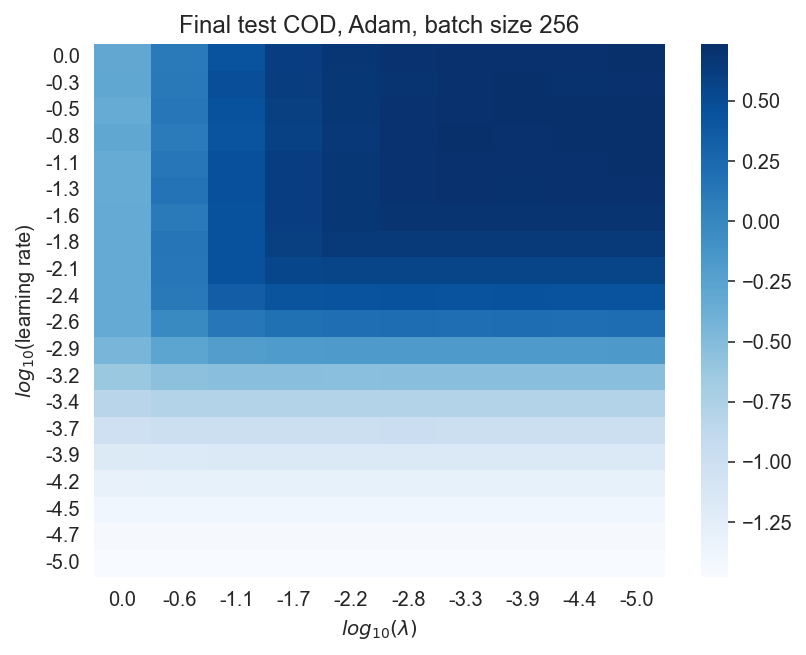

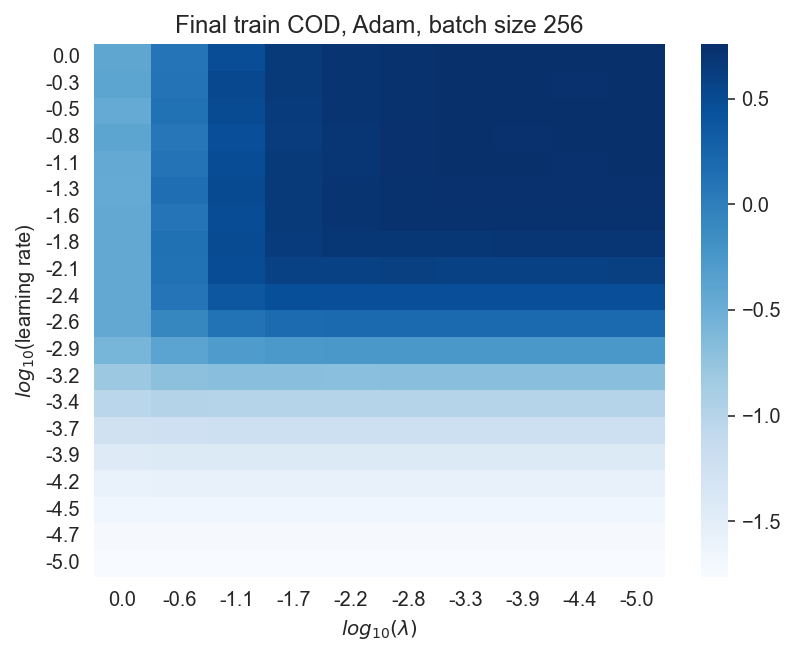

In [50]:
adam_results = ridge_loop(batch_size=256, optimizer_class=opt.ADAM, var_shape=(10))

for tensor, desc in zip(
        adam_results,
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor, cmap=plt.cm.Blues, xticklabels=np.round(np.log10(default_l2_rates), 1),
            yticklabels=np.round(np.log10(default_learning_rates), 1))
    ax.set(title=f'Final {desc}, Adam, batch size 50', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.show()

## Scikit-learn's SGD model

In [51]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
sklearn_test_mse = tf.Variable(tf.zeros((len(default_learning_rates), len(default_l2_rates)), dtype=tf.float32))
sklearn_train_mse = tf.Variable(tf.zeros((len(default_learning_rates), len(default_l2_rates)), dtype=tf.float32))
sklearn_test_cod = tf.Variable(tf.zeros((len(default_learning_rates), len(default_l2_rates)), dtype=tf.float32))
sklearn_train_cod = tf.Variable(tf.zeros((len(default_learning_rates), len(default_l2_rates)), dtype=tf.float32))
for lr_id, l2_id in product(range(len(default_learning_rates)), range(len(default_l2_rates))):
    reg = SGDRegressor(max_iter=100, tol=1e-3, penalty='l2',learning_rate='constant', eta0=default_learning_rates[lr_id], alpha=default_l2_rates[l2_id])
    reg.fit(X_train, Z_train)


    sklearn_test_mse[lr_id, l2_id].assign(mse(Z_test, reg.predict(X_test)))
    sklearn_train_mse[lr_id, l2_id].assign(mse(Z_train, reg.predict(X_train)))
    sklearn_test_cod[lr_id, l2_id].assign(cod(Z_test, reg.predict(X_test)))
    sklearn_train_cod[lr_id, l2_id].assign(cod(Z_train, reg.predict(X_train)))

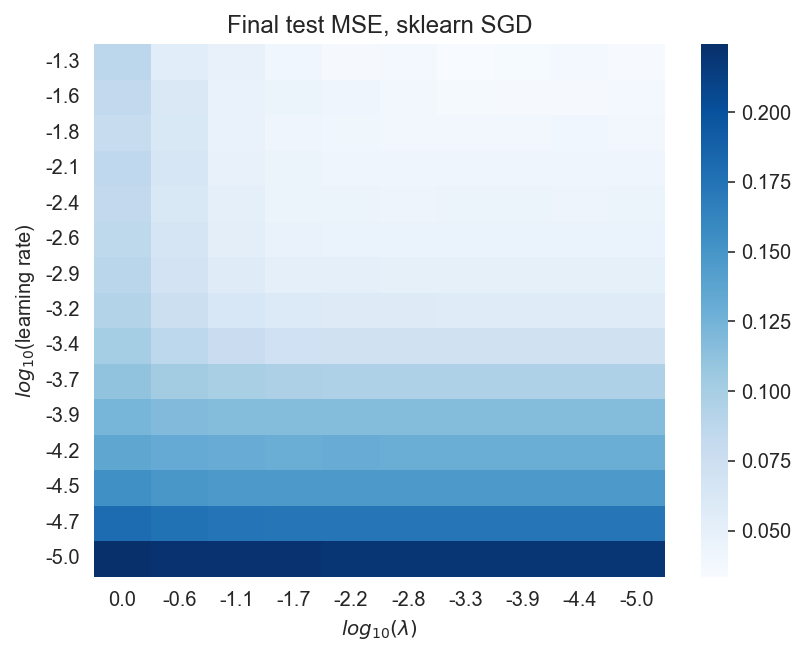

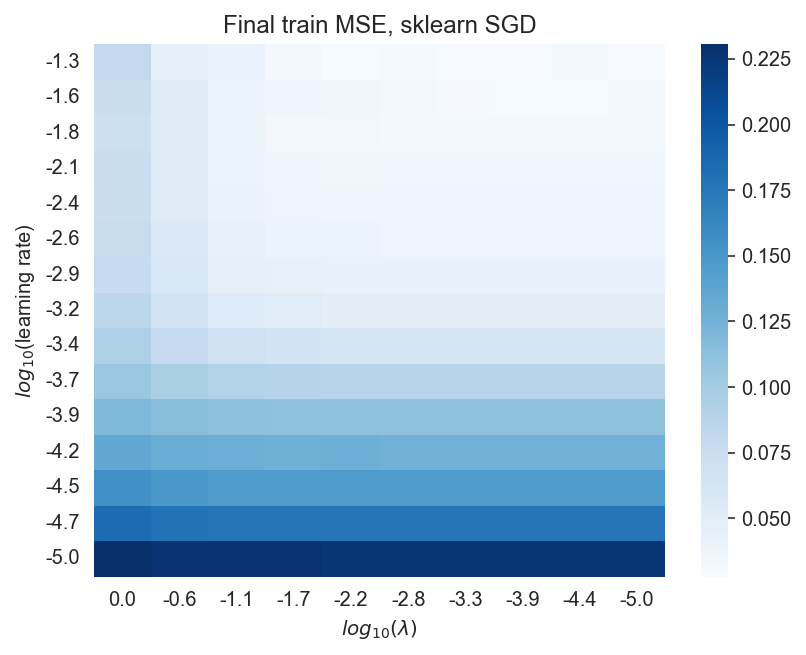

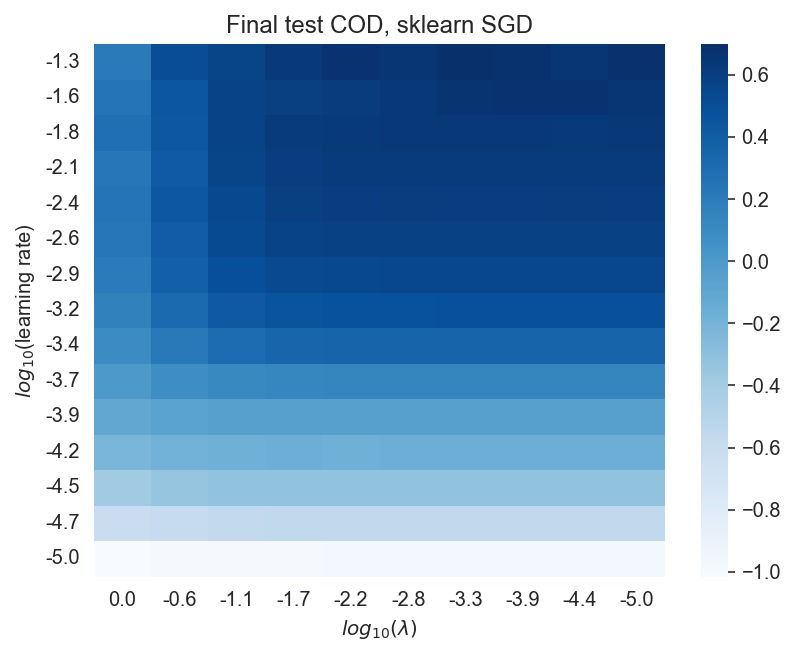

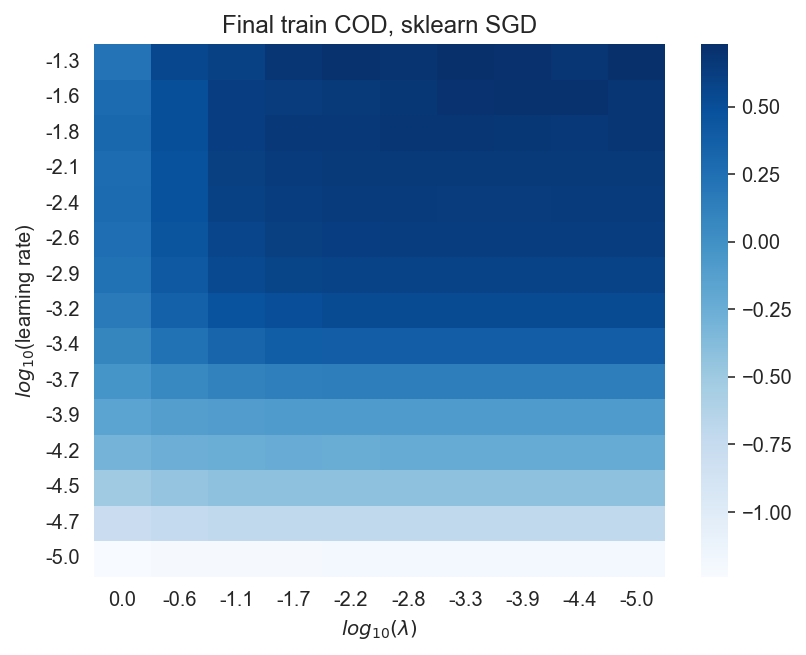

In [53]:
for tensor, desc in zip(
        (sklearn_test_mse, sklearn_train_mse, sklearn_test_cod, sklearn_train_cod),
        ('test MSE', 'train MSE', 'test COD', 'train COD')
):
    fig, ax = plt.subplots(dpi=144)
    heatmap(tensor[5:, ...], cmap=plt.cm.Blues, xticklabels=np.round(np.log10(default_l2_rates), 1),
            yticklabels=np.round(np.log10(default_learning_rates[5:, ...]), 1))
    ax.set(title=f'Final {desc}, sklearn SGD', ylabel=r"$log_{10}$(learning rate)", xlabel=r"$log_{10}(\lambda)$")
    plt.yticks(rotation=0)

    plt.show()